- By: Proskurin Oleksandr
- Email: proskurinolexandr@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 37-38

# Introduction. Why Futures Roll Trick?

In almost any futures trading algorithm we need to track continuous contract (for example first-month contract). However, the problem is that, when expiration comes there is a price difference between contract which expires and the next contract. Usually this difference is small, however for some commodity contracts which are rolled on quarterly basis it can be quite substancial (especially if commodity underlying carry costs are high). 
Consider the example. 
September futures contract on wheat expires December 2019, the next contract is March 2020. On roll December expiration date the prices are:
- December contract close price: 100
- March contract open price: 120

One can ignore price difference and simply say that now the price of the first contract is 120. What are the disadvantages of this approach? If you build your machine learning model, it will learn that on the expiration dates the nearest contract price dramatically drops/rises which is actually not a tradable opportunity, however the model will learn that difference and will constantly generate trading signals on expiration dates. How can we deal with that? The answer is __Futures Roll Trick__
One can subtract difference between open of the next contract and close of expiring contract (120-100 = 20) and constantly subtract this difference further if he wants to preserve absolute returns. If a researcher wants to preserve relative return he can divide next contract open by expiring contract close and divide further values by this adjustment factor.

__Final Note__: on further expirations adjustment factor = previous_adjustment_factor + new_roll_gap for absolute returns,
adjustment_factor = previous_adjustment_factor * new_roll_gap for relative returns

Let's look how Futures Roll Trick works on the example of ES futures roll

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlfinlab as ml
import seaborn as sns

In [2]:
aggregated_df = pd.read_csv('../Sample-Data/volume_bars_es_with_nearest_contract.csv', index_col = 0, parse_dates = [0])

In [3]:
aggregated_df.head()

,open,high,low,close,volume,ticker,nearest_contract
date_time,,,,,,,
2011-01-02 21:50:39,1256.00,1261.0,1255.25,1260.00,20015,ESH11,ESH11
2011-01-03 02:00:37,1260.00,1261.5,1258.50,1258.75,20006,ESH11,ESH11
2011-01-03 02:47:12,1258.75,1261.5,1258.50,1260.00,20040,ESH11,ESH11
2011-01-03 04:11:34,1260.00,1261.0,1259.00,1260.50,20146,ESH11,ESH11
2011-01-03 06:01:23,1260.50,1261.5,1260.50,1260.50,20005,ESH11,ESH11


# Generate futures roll gaps

In [4]:
# Get roll gaps (absolute and relative)
roll_gaps_diff = ml.multi_product.get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                                   sec_col='ticker', current_sec_col='nearest_contract')
roll_gaps_relative = ml.multi_product.get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                                   sec_col='ticker', current_sec_col='nearest_contract', method='relative')

In [5]:
first_contract = aggregated_df[aggregated_df.ticker == aggregated_df.nearest_contract] # Filter out only the first contract

Subtract/divide gaps from close prices

In [6]:
first_contract_diff_method = first_contract.copy()
first_contract_div_method = first_contract.copy()

first_contract_diff_method['close'] -= roll_gaps_diff
first_contract_div_method['close'] /= roll_gaps_relative

Plot nearest continuous futures contract using different fill methods

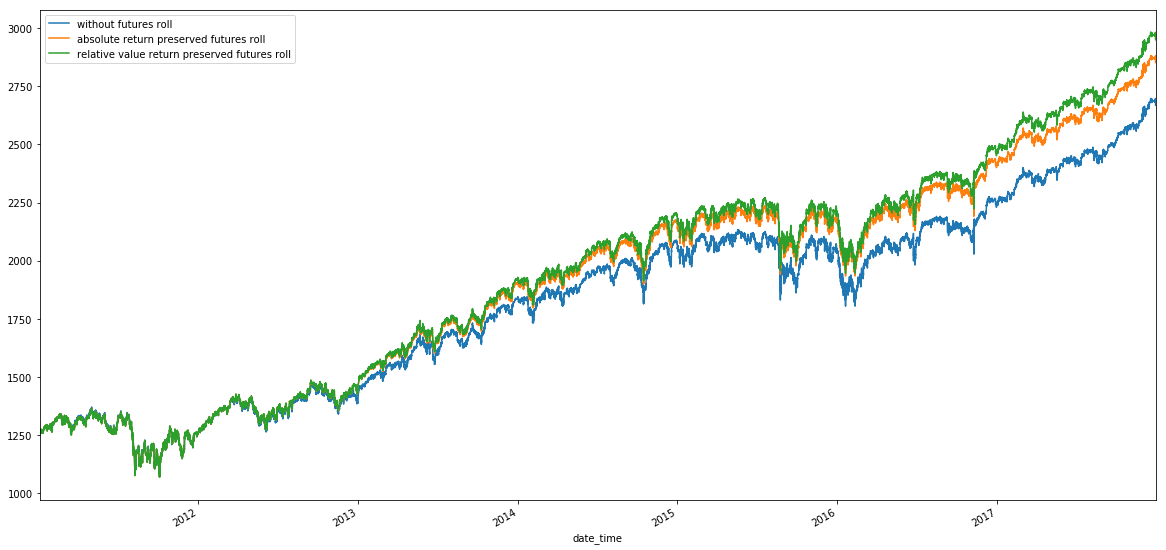

In [7]:
plt.figure(figsize=(20, 10))

first_contract.close.plot(label = 'without futures roll')
first_contract_diff_method.close.plot(label = 'absolute return preserved futures roll')
first_contract_div_method.close.plot(label = 'relative value return preserved futures roll')
plt.legend(loc='best')
plt.show()

# Conclusion

As you can see events on ES futures gaps can be quite substantial and bring additional noise to your model. Based on model goals, researcher can choose which returns he would like to preserve: relative or absolute.